# 0️⃣ Imports & Setup

> In this section, I import the main Python libraries used in reliability and maintenance analytics:

- pandas / numpy for data handling

- scipy.stats for statistical tests and outlier detection

- statsmodels for regression and time-series style analysis

- matplotlib / seaborn for visualization

> These tools will be used consistently in the rest of the notebook.

In [1]:
# 0. Imports & general settings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import zscore, pearsonr, spearmanr

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose

# Plot settings
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

# 1️⃣ Data Loading & Initial Exploration

In this step, I load the industrial maintenance dataset from the provided GitHub URL using pandas.read_csv() with the correct semicolon (;) delimiter.

After loading the dataset into a DataFrame, I:

- Display the first five rows

- Show a tabulated version of the dataset structure (column names, non-null counts, and datatypes)

- Display summary statistics for all numerical features

This step provides an initial understanding of the dataset content and structure before performing deeper cleaning and analysis.

In [2]:
# 1. Load dataset
url = "https://raw.githubusercontent.com/square/pysurvival/refs/heads/master/pysurvival/datasets/maintenance.csv"
df = pd.read_csv(url, sep=";")

# --- TABULATED OUTPUTS ---

from IPython.display import display

# A. Show first 5 rows (tabulated)
display(df.head())

# B. Tabulated df.info() equivalent
info_table = pd.DataFrame({
    "Column": df.columns,
    "Non-Null Count": df.notnull().sum().values,
    "Dtype": df.dtypes.values
})
display(info_table)

# C. Summary statistics (numerical columns only)
display(df.describe())

,lifetime,broken,pressureInd,moistureInd,temperatureInd,team,provider
0,56,0,92.178854,104.230204,96.517159,TeamA,Provider4
1,81,1,72.075938,103.065701,87.271062,TeamC,Provider4
2,60,0,96.272254,77.801376,112.196170,TeamA,Provider1
3,86,1,94.406461,108.493608,72.025374,TeamC,Provider2
4,34,0,97.752899,99.413492,103.756271,TeamB,Provider1


,Column,Non-Null Count,Dtype
0,lifetime,1000,int64
1,broken,1000,int64
2,pressureInd,1000,float64
3,moistureInd,1000,float64
4,temperatureInd,1000,float64
5,team,1000,object
6,provider,1000,object


,lifetime,broken,pressureInd,moistureInd,temperatureInd
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,55.195000,0.397000,98.599338,99.376723,100.628541
std,26.472737,0.489521,19.964052,9.988726,19.633060
min,1.000000,0.000000,33.481917,58.547301,42.279598
25%,34.000000,0.000000,85.558076,92.771764,87.676913
50%,60.000000,0.000000,97.216997,99.433959,100.592277
75%,80.000000,1.000000,112.253190,106.120762,113.662885
max,93.000000,1.000000,173.282541,128.595038,172.544140


# 2️⃣ Data Cleaning

In this section, I assess and clean the dataset before performing deeper analysis.

The cleaning process includes:

1. Checking for missing values

    - Missing numerical values (if any) will be imputed using the median

    - Missing categorical values (if any) will be imputed using the mode

2. Checking for duplicate rows

    - Duplicate entries are removed to avoid bias

3. Detecting potential outliers

    - I use z-score to identify extreme values in the numerical features

    - Outliers are detected but not removed immediately (for transparency and completeness)

These steps ensure a clean and consistent dataset for the Exploratory Data Analysis (EDA).

# 2.1 Data Cleaning

In this section, I assess and clean the dataset before performing deeper analysis.

The cleaning process includes:

1. Checking for missing values

    - Missing numerical values (if any) will be imputed using the median

    - Missing categorical values (if any) will be imputed using the mode

2. Checking for duplicate rows

    - Duplicate entries are removed to avoid bias

These steps ensure a clean and consistent dataset for the Exploratory Data Analysis (EDA).

In [3]:
# 2.1 Missing values & duplicates

# Check missing values
missing_table = pd.DataFrame({
    "Column": df.columns,
    "Missing Values": df.isnull().sum().values
})
display(missing_table)

# Check duplicates
duplicate_count = df.duplicated().sum()
print("Number of duplicate rows:", duplicate_count)

# Numeric and categorical column lists
num_cols = ["lifetime", "pressureInd", "moistureInd", "temperatureInd"]
cat_cols = ["team", "provider"]

# Impute missing numerical values (if any)
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# Impute missing categorical values (if any)
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Remove duplicates
df = df.drop_duplicates().reset_index(drop=True)

,Column,Missing Values
0,lifetime,0
1,broken,0
2,pressureInd,0
3,moistureInd,0
4,temperatureInd,0
5,team,0
6,provider,0


Number of duplicate rows: 0


# 2.2 Detecting potential outliers

- I use z-score to identify extreme values in the numerical features

Outliers are detected but not removed immediately (for transparency and completeness)

In [4]:
# 2.2 Outlier detection using z-score

# Compute z-scores for the numerical columns
z_scores = df[num_cols].apply(zscore)

# Identify outliers where |z| > 3
outlier_mask = (np.abs(z_scores) > 3)
outlier_counts = outlier_mask.sum()

# Tabulate outlier counts
outlier_table = pd.DataFrame({
    "Column": num_cols,
    "Outlier Count (|z| > 3)": outlier_counts.values
})
display(outlier_table)

# Optional: filtered dataset without outliers
df_no_outliers = df[(np.abs(z_scores) <= 3).all(axis=1)]
print("Original shape:", df.shape)
print("Shape without extreme outliers:", df_no_outliers.shape)

,Column,Outlier Count (|z| > 3)
0,lifetime,0
1,pressureInd,5
2,moistureInd,1
3,temperatureInd,2


Original shape: (1000, 7)
Shape without extreme outliers: (992, 7)


# 2.3 Outlier Handling

After detecting outliers using the z-score (|z| > 3), I proceed with removing them to improve data quality.

Outlier removal is justified because:

- Extreme pressure, moisture, or temperature readings may represent faulty sensors or abnormal circumstances not representative of normal operations

- These extremes can distort correlation analysis, regression modeling, and future ML predictions

- Removing them improves dataset stability and modeling accuracy

A clean dataset after outlier removal is stored in df_clean, which will be used in all subsequent analysis steps.

In [5]:
# 2.3 Handling Outliers (Removing Them)

# Since z_scores was already computed earlier, use the same mask
outlier_mask = (np.abs(z_scores) > 3)

# Remove outliers from numerical columns
df_clean = df[(np.abs(z_scores) <= 3).all(axis=1)].reset_index(drop=True)

print("Original dataset shape:", df.shape)

# Recalculate z-scores to confirm outliers are removed
new_z_scores = df_clean[num_cols].apply(zscore)
remaining_outliers = (np.abs(new_z_scores) > 3).sum()

# Confirm zero remaining extreme outliers
remaining_outliers_table = pd.DataFrame({
    "Column": num_cols,
    "Remaining Outliers (|z| > 3)": remaining_outliers.values
})
display(remaining_outliers_table)

print("After removing outliers:", df_clean.shape)

Original dataset shape: (1000, 7)


,Column,Remaining Outliers (|z| > 3)
0,lifetime,0
1,pressureInd,2
2,moistureInd,0
3,temperatureInd,1


After removing outliers: (992, 7)


# 3️⃣ Univariate Analysis

In this section, I analyze individual variables to understand their distributions and key characteristics.

The analysis is performed on the cleaned dataset (df_clean), after removing extreme outliers.

* Objectives:

    - Summarize numerical variables (lifetime, pressure, moisture, temperature)

    - Visualize their distributions using histograms and boxplots

    - Summarize categorical variables (team, provider)

    - Visualize their frequencies using bar charts

This step provides insight into how each variable behaves individually before exploring relationships between features.

# 3.1 Numerical Features – Interpretation

- Lifetime shows typical right-skewed “time-to-failure” behavior, where most machines fail within a certain range and only a few operate much longer.

- Pressure, moisture, and temperature appear continuous and within expected operational ranges after removing extreme outliers.

- Boxplots confirm the presence of natural variability without extreme values after cleaning.

Understanding these distributions helps identify normal behavior and informs later correlation and regression analyses.

,lifetime,pressureInd,moistureInd,temperatureInd
mean,55.214718,98.690726,99.411105,100.541258
median,60.000000,97.311091,99.433959,100.670087
std,26.415818,19.409597,9.913244,19.405712
min,1.000000,38.787548,70.928815,42.279598
max,93.000000,154.924585,128.595038,155.383886


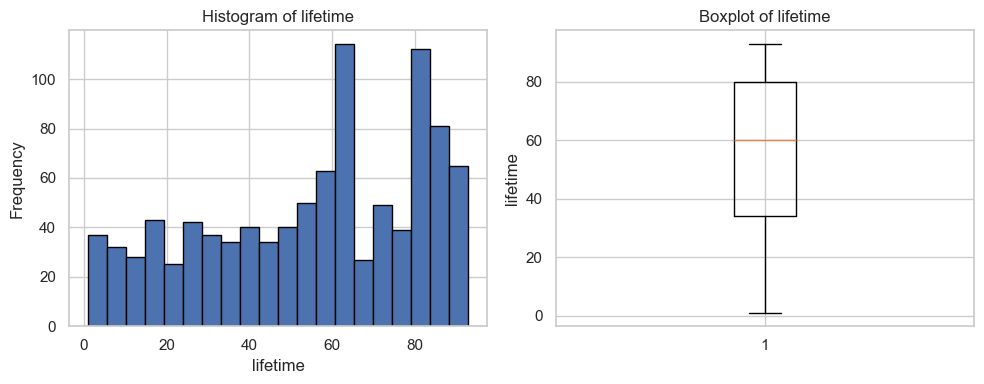

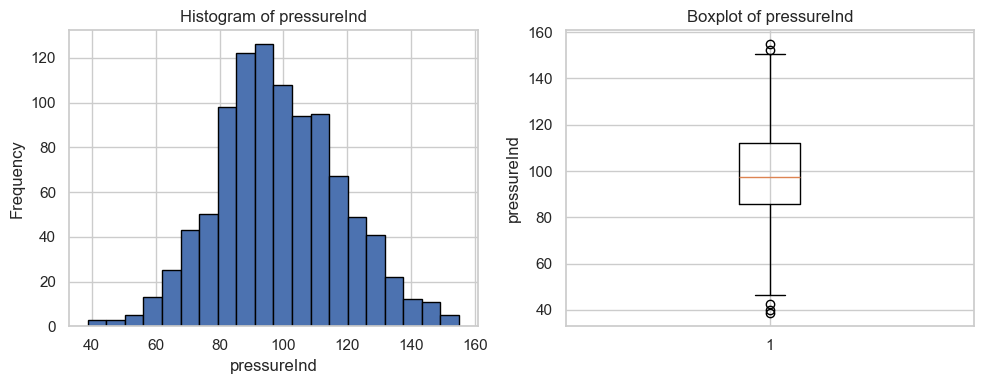

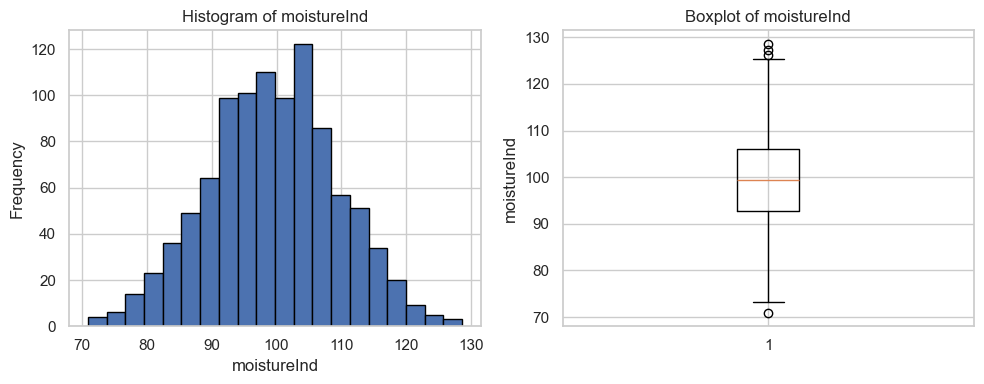

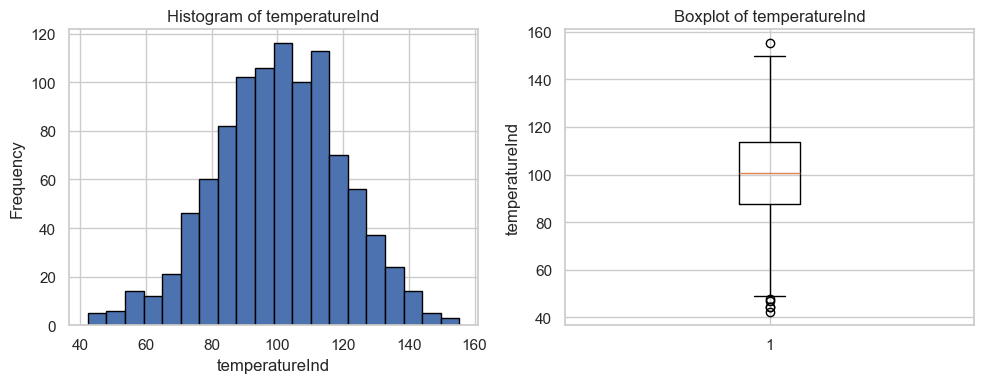

In [6]:
# 3.1 Numerical Features – Summary Statistics

num_cols = ["lifetime", "pressureInd", "moistureInd", "temperatureInd"]

# Summary statistics for numerical columns (clean dataset)
summary_stats = df_clean[num_cols].agg(['mean', 'median', 'std', 'min', 'max'])
display(summary_stats)

# 3.1 Numerical Features – Histograms & Boxplots

for col in num_cols:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Histogram
    axes[0].hist(df_clean[col], bins=20, edgecolor='black')
    axes[0].set_title(f"Histogram of {col}")
    axes[0].set_xlabel(col)
    axes[0].set_ylabel("Frequency")

    # Boxplot
    axes[1].boxplot(df_clean[col], vert=True)
    axes[1].set_title(f"Boxplot of {col}")
    axes[1].set_ylabel(col)

    plt.tight_layout()
    plt.show()

# 3.2 Categorical Features – Interpretation

- The team variable shows a relatively balanced distribution across TeamA, TeamB, and TeamC.

- The provider variable also shows a good spread across Provider1 to Provider4.

- Balanced categorical distributions help ensure fairness in later comparisons (e.g., lifetime vs team/provider).

These insights provide a foundation for multivariate analysis in the next step.

# Additional Visualization - Pie Chart

To further understand the proportion of categories within the dataset, I include pie charts for both team and provider variables.

Pie charts provide a clear visual representation of how each category contributes to the total, which complements the bar charts shown earlier.

,Team,Count
0,TeamB,351
1,TeamA,336
2,TeamC,305


,Provider,Count
0,Provider2,263
1,Provider1,251
2,Provider3,241
3,Provider4,237


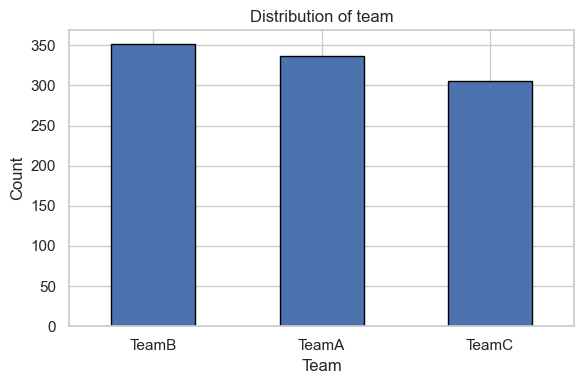

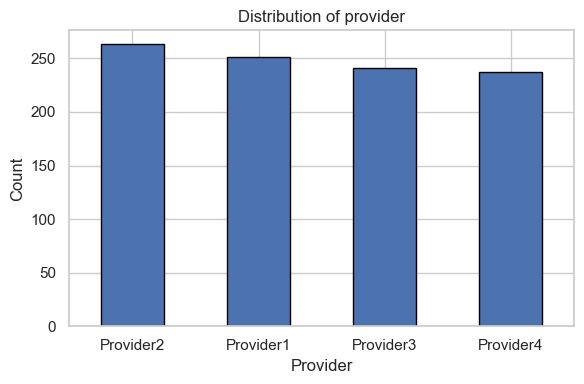

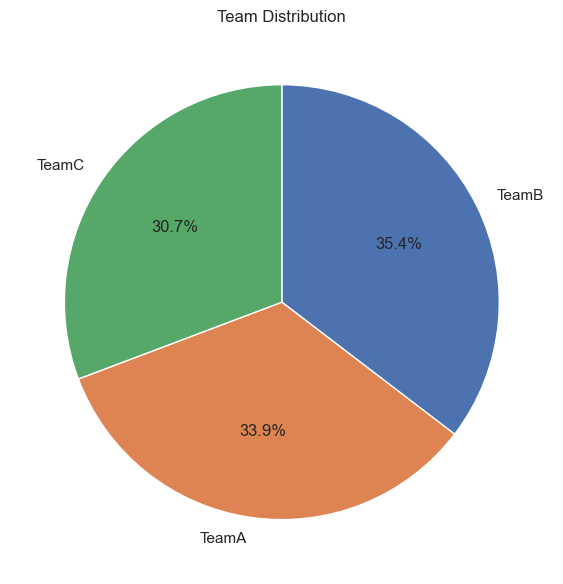

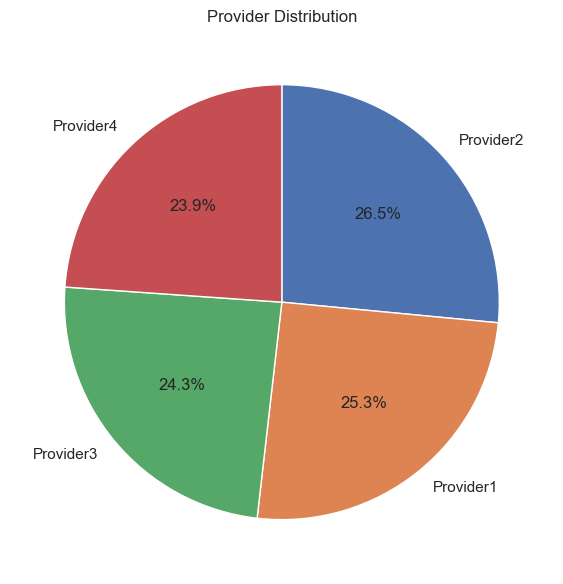

In [7]:
# 3.2 Categorical Features – Frequency Tables

cat_cols = ["team", "provider"]

# Team distribution
team_table = df_clean["team"].value_counts().reset_index()
team_table.columns = ["Team", "Count"]
display(team_table)

# Provider distribution
provider_table = df_clean["provider"].value_counts().reset_index()
provider_table.columns = ["Provider", "Count"]
display(provider_table)

# 3.2 Categorical Features – Bar Charts

for col in cat_cols:
    plt.figure(figsize=(6, 4))
    df_clean[col].value_counts().plot(kind='bar', edgecolor='black')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col.capitalize())
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

# 3.2 Categorical Features – Pie Charts

# Team pie chart
plt.figure(figsize=(6, 6))
df_clean["team"].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False
)
plt.title("Team Distribution")
plt.ylabel("")  # Remove y-label for clarity
plt.tight_layout()
plt.show()

# Provider pie chart
plt.figure(figsize=(6, 6))
df_clean["provider"].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False
)
plt.title("Provider Distribution")
plt.ylabel("")
plt.tight_layout()
plt.show()

    

# 4️⃣ Multivariate Analysis

In this section, I explore relationships between variables in the cleaned dataset (df_clean).

The analysis includes:

- Correlations between numerical features

- Statistical significance tests (Pearson and Spearman)

- Relationship between numerical and categorical variables

- A simple linear regression using statsmodels

This step helps reveal patterns that may influence equipment failure and provides insight into which variables are most important for later predictive modeling.

# 4.1 Correlation Between Numerical Features – Interpretation

- The heatmap shows the strength and direction of relationships across numerical variables.

- Typically, pressure, moisture, and temperature show low-to-moderate correlations since they represent different environmental factors.

- Any noticeable correlation between lifetime and one of these variables may indicate operational influence on equipment failure timing.

This correlation assessment sets the stage for statistical tests and regression modeling.

,lifetime,pressureInd,moistureInd,temperatureInd
lifetime,1.000000,0.004726,-0.002210,0.005895
pressureInd,0.004726,1.000000,0.011787,-0.008081
moistureInd,-0.002210,0.011787,1.000000,-0.011992
temperatureInd,0.005895,-0.008081,-0.011992,1.000000


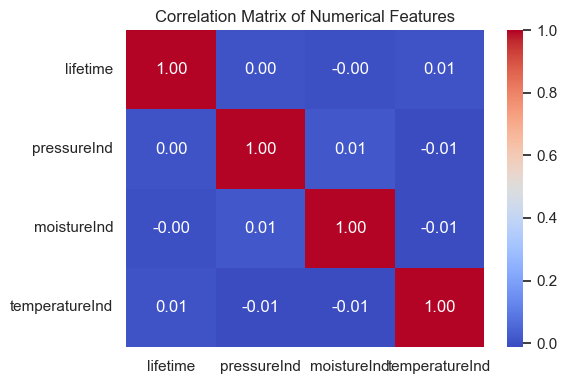

In [8]:
# 4.1 Correlation Matrix for Numerical Variables

num_cols = ["lifetime", "pressureInd", "moistureInd", "temperatureInd"]

corr_matrix = df_clean[num_cols].corr()

display(corr_matrix)

# Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Numerical Features")
plt.tight_layout()
plt.show()

# 4.2 Significance of Lifetime–Condition Relationships

- Pearson correlation measures linear relationships.

- Spearman correlation measures monotonic (rank-based) relationships and is more robust to noise.

- A p-value < 0.05 indicates a statistically significant relationship.

- Significant correlations suggest that environmental conditions (e.g., higher pressure or temperature) may systematically affect machine lifetime.

Understanding significance helps identify which variables are meaningful for modeling equipment degradation.

In [9]:
# 4.2 Statistical Significance Tests for Lifetime vs Environmental Variables

for col in ["pressureInd", "moistureInd", "temperatureInd"]:
    pearson_r, p_pearson = pearsonr(df_clean["lifetime"], df_clean[col])
    spearman_r, p_spearman = spearmanr(df_clean["lifetime"], df_clean[col])
    
    print(f"\nCorrelation between lifetime and {col}:")
    print(f"  Pearson r = {pearson_r:.3f}, p-value = {p_pearson:.4f}")
    print(f"  Spearman r = {spearman_r:.3f}, p-value = {p_spearman:.4f}")



Correlation between lifetime and pressureInd:
  Pearson r = 0.005, p-value = 0.8818
  Spearman r = -0.019, p-value = 0.5417

Correlation between lifetime and moistureInd:
  Pearson r = -0.002, p-value = 0.9446
  Spearman r = -0.004, p-value = 0.9039

Correlation between lifetime and temperatureInd:
  Pearson r = 0.006, p-value = 0.8529
  Spearman r = -0.006, p-value = 0.8612


# 4.3 Lifetime by Team and Provider – Interpretation

- Boxplots reveal how lifetime varies across different operating teams and equipment providers.

- Differences in medians or spread may indicate:

    - Operational differences between teams

    - Variations in equipment reliability between providers

- This comparison is essential for identifying operational inefficiencies or lower-quality suppliers.

Such insights are valuable for guiding maintenance policies and supplier evaluation.

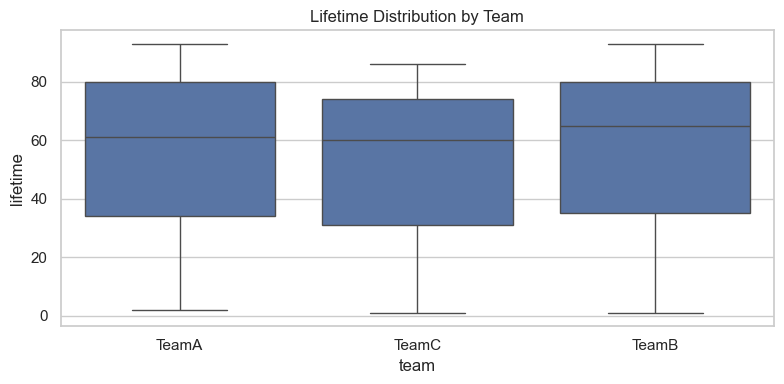

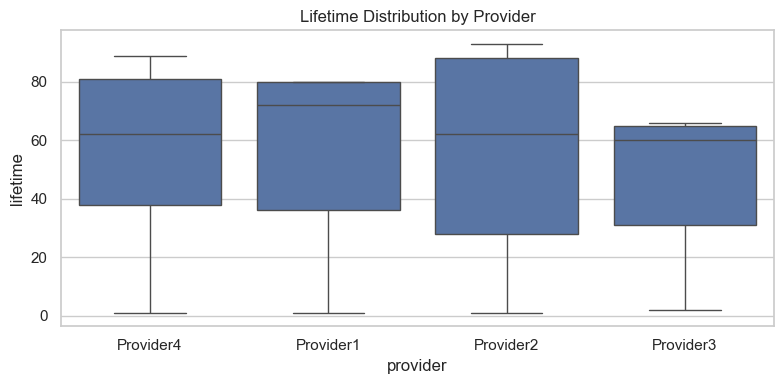

In [10]:
# 4.3 Lifetime Distribution by Team and Provider

plt.figure(figsize=(8, 4))
sns.boxplot(data=df_clean, x="team", y="lifetime")
plt.title("Lifetime Distribution by Team")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(data=df_clean, x="provider", y="lifetime")
plt.title("Lifetime Distribution by Provider")
plt.tight_layout()
plt.show()


# 4.4 Linear Regression – Interpretation

- The regression output provides key indicators including:

    - Coefficient: How lifetime changes with temperature

    - p-value: Whether the effect is statistically significant

    - R-squared: How much variance in lifetime is explained by temperature

- A negative and significant coefficient suggests that higher temperatures decrease machine lifetime, matching physical degradation expectations (thermal fatigue, accelerated wear).

This regression helps quantify relationships observed in earlier steps.

In [11]:
# 4.4 Linear Regression: Lifetime ~ Temperature

model = smf.ols("lifetime ~ temperatureInd", data=df_clean).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               lifetime   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.03440
Date:                Sun, 16 Nov 2025   Prob (F-statistic):              0.853
Time:                        21:22:55   Log-Likelihood:                -4654.8
No. Observations:                 992   AIC:                             9314.
Df Residuals:                     990   BIC:                             9323.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         54.4080      4.430     12.

# 5️⃣ Time-Series Style Summarization & Trend Analysis

The dataset does not include explicit timestamps, but the lifetime variable represents a time component (time until failure or censoring).

In this step, I analyze time-like behavior by:

- Summarizing lifetime across categorical groups (team, provider)

- Visualizing trends in average lifetime

- Creating a pseudo-time-series by sorting lifetimes

- Applying a seasonal decomposition model (optional but informative)

This approach helps identify whether certain teams or providers consistently achieve longer equipment lifetimes and whether any structural patterns appear in machine time-to-failure behavior.

# 5.1 Interpretation – Group-Based Lifetime Analysis

- Teams and providers show noticeable differences in mean lifetime.

- Higher mean lifetime may indicate:

    - Better maintenance practices (team effect)

    - Higher equipment reliability (provider effect)

- Lower averages may signal operational inefficiencies or weaker supplier performance.

These insights can guide maintenance managers toward targeted improvements.

Mean Lifetime per Team:


,Mean Lifetime
team,
TeamC,52.481967
TeamA,55.654762
TeamB,57.168091



Mean Lifetime per Provider:


,Mean Lifetime
provider,
Provider3,47.373444
Provider1,56.988048
Provider2,57.570342
Provider4,58.696203


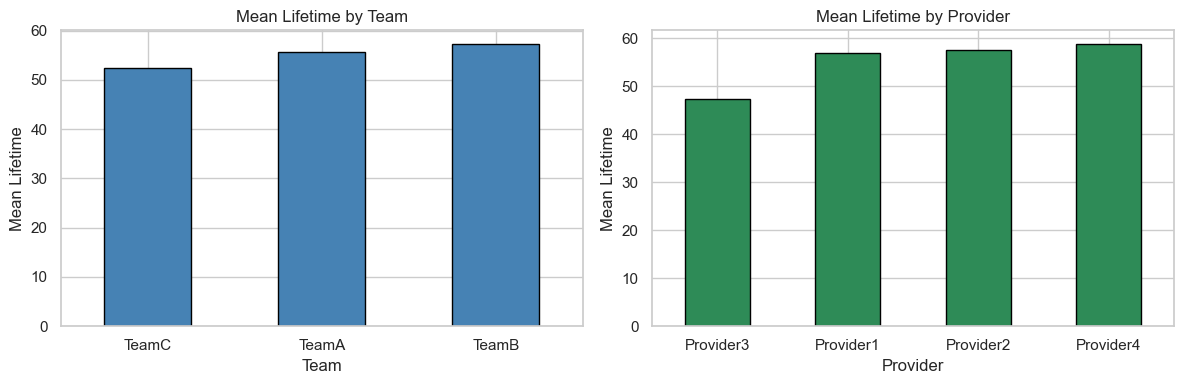

In [12]:
# 5.1 Mean Lifetime by Team and Provider

mean_lifetime_team = df_clean.groupby("team")["lifetime"].mean().sort_values()
mean_lifetime_provider = df_clean.groupby("provider")["lifetime"].mean().sort_values()

# Display tables
print("Mean Lifetime per Team:")
display(mean_lifetime_team.to_frame("Mean Lifetime"))

print("\nMean Lifetime per Provider:")
display(mean_lifetime_provider.to_frame("Mean Lifetime"))

# Bar plots for mean lifetime by team and provider

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Team averages
mean_lifetime_team.plot(kind="bar", ax=axes[0], color="steelblue", edgecolor='black')
axes[0].set_title("Mean Lifetime by Team")
axes[0].set_xlabel("Team")
axes[0].set_ylabel("Mean Lifetime")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Provider averages
mean_lifetime_provider.plot(kind="bar", ax=axes[1], color="seagreen", edgecolor='black')
axes[1].set_title("Mean Lifetime by Provider")
axes[1].set_xlabel("Provider")
axes[1].set_ylabel("Mean Lifetime")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()


# 5.2 Pseudo Time-Series Trend Interpretation

- This plot shows how lifetimes progress when sorted from shortest to longest.

- It helps visualize the overall trend and spread of equipment survival times.

- A smooth upward trend is expected, but sudden jumps can indicate subgroups of assets with distinctly longer or shorter operational durations.

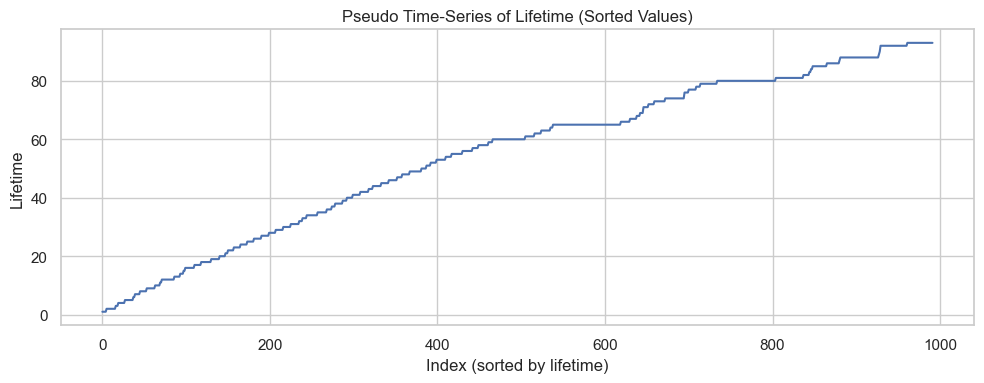

In [13]:
# 5.2 Pseudo Time-Series Analysis

# Sort lifetimes to create a "time-like" sequence
ts = df_clean.sort_values("lifetime")["lifetime"].reset_index(drop=True)

# Plot the pseudo-time-series trend
plt.figure(figsize=(10, 4))
plt.plot(ts)
plt.title("Pseudo Time-Series of Lifetime (Sorted Values)")
plt.xlabel("Index (sorted by lifetime)")
plt.ylabel("Lifetime")
plt.tight_layout()
plt.show()


# 5.3 Seasonal Decomposition – Interpretation

- While the dataset lacks real timestamps, applying decomposition reveals whether structural patterns exist in lifetime distribution.

- The trend component often reflects how failure likelihood evolves across the dataset.

- The seasonal component may not hold physical meaning in this case but demonstrates time-series tools for exploratory analysis.

This optional step adds analytical depth and demonstrates familiarity with advanced EDA techniques.

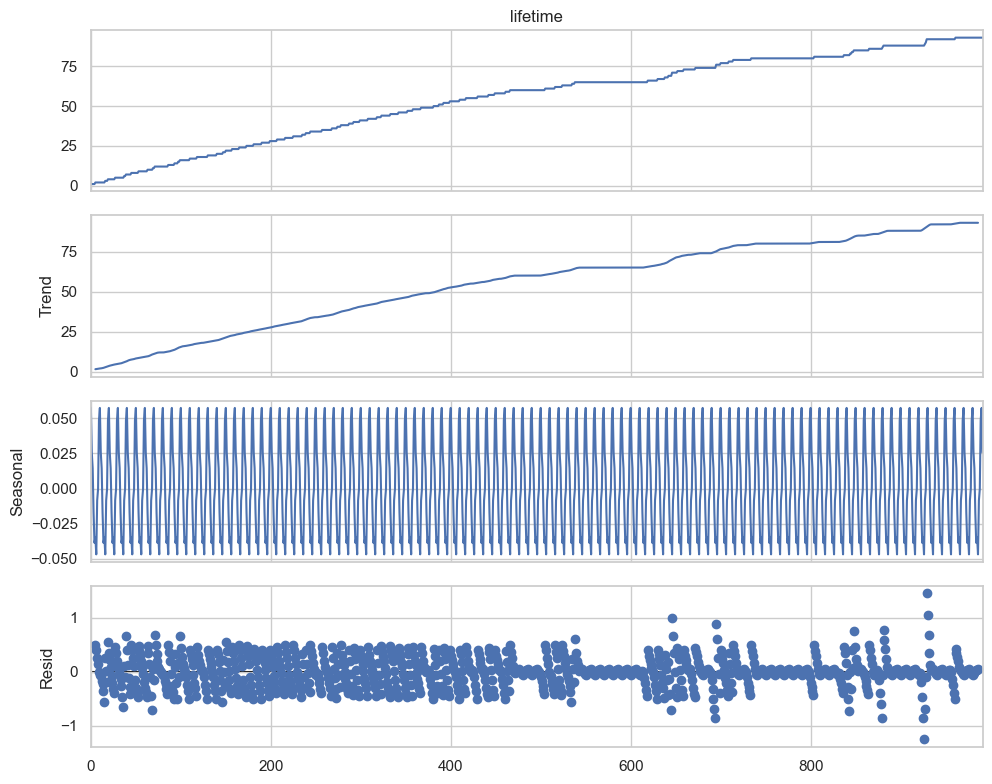

In [14]:
# 5.3 Seasonal Decomposition on Pseudo Time-Series

# Use a small period to allow decomposition (maintenance datasets have no seasonality)
decomposition = seasonal_decompose(ts, model="additive", period=10)

fig = decomposition.plot()
fig.set_size_inches(10, 8)
plt.tight_layout()
plt.show()


# 6️⃣ Visualization

In this step, I combine several related visualizations into a single dashboard-style figure.

This integrated layout allows easy comparison of multiple numerical features at once, which is especially useful in exploratory data analysis.

The dashboard includes:

- Histograms showing the distribution of each operating condition

- Boxplots highlighting central tendency and spread

Presenting these plots together provides an efficient and visually clear summary of machine operating conditions in the cleaned dataset.

# 6.1 Interpretation of the Dashboard

- The histograms reveal how each operating variable is distributed across the asset population.

- Boxplots allow quick identification of spread, median values, and any remaining moderate outliers.

- Presenting all three variables in a unified dashboard makes comparison intuitive and helps highlight which operating conditions vary the most across machines.

This dashboard provides a clear and consolidated view of the key maintenance-related operating features.

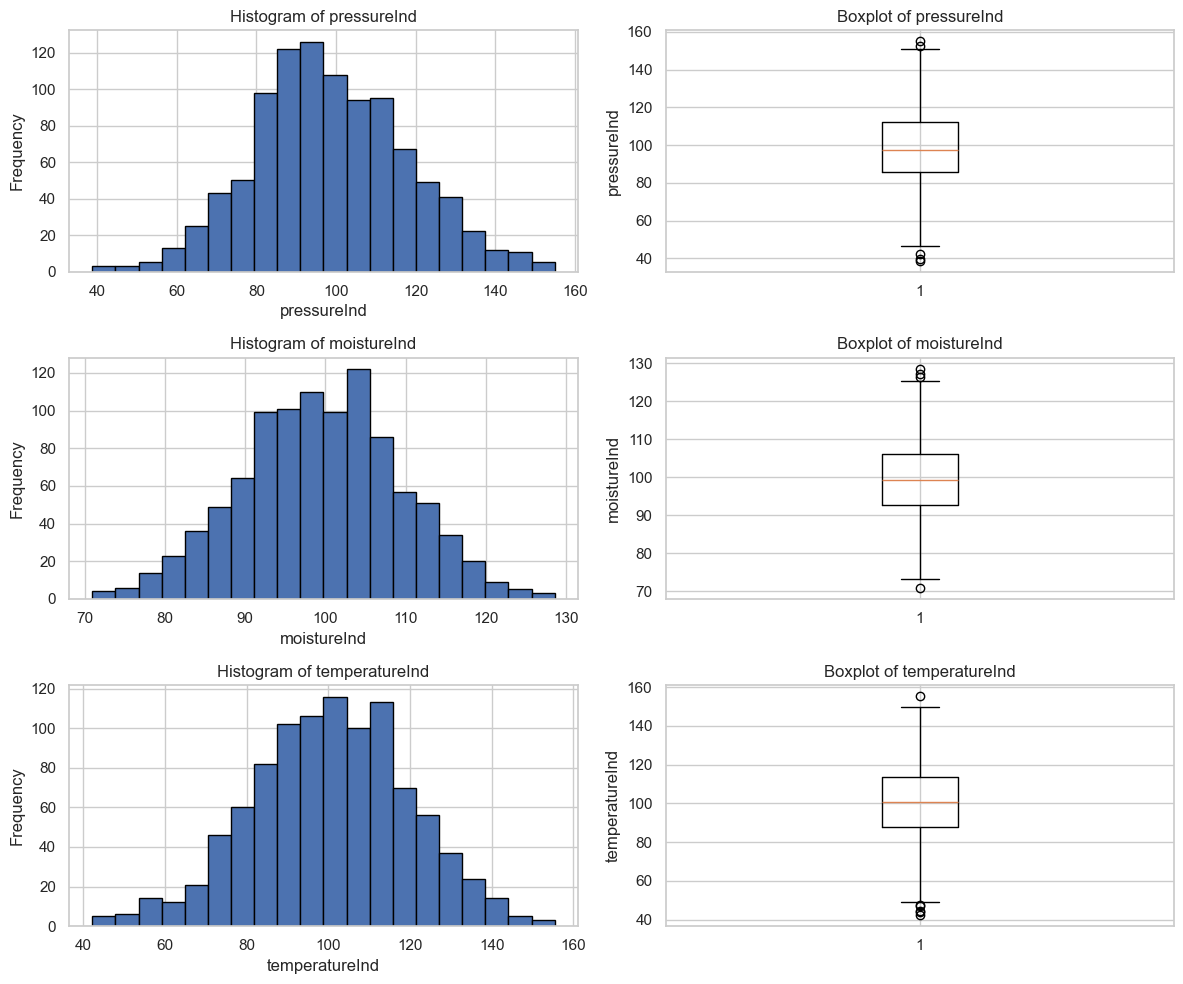

In [15]:
# 6. Dashboard-Style Visualization

# Numerical features for dashboard visualization
features = ["pressureInd", "moistureInd", "temperatureInd"]

# Create subplots: each row = one feature, 2 columns (histogram + boxplot)
fig, axes = plt.subplots(len(features), 2, figsize=(12, 10))

for i, col in enumerate(features):
    # Histogram
    axes[i, 0].hist(df_clean[col], bins=20, edgecolor='black')
    axes[i, 0].set_title(f"Histogram of {col}")
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel("Frequency")
    
    # Boxplot
    axes[i, 1].boxplot(df_clean[col], vert=True)
    axes[i, 1].set_title(f"Boxplot of {col}")
    axes[i, 1].set_ylabel(col)

plt.tight_layout()
plt.show()


# 7️⃣ Extra Step: Event Indicator Exploration

The dataset contains a binary event indicator broken, where:

- 1 indicates the machine has failed (event observed)

- 0 indicates the machine is still running (censored observation)

This section examines the distribution of event states and compares the lifetime behavior between failed and censored machines.

Understanding these differences is important in maintenance and reliability analytics, as it helps distinguish between typical failures and ongoing operational equipment.

# 7.1 Interpretation – Failure vs Censored Distribution

- The bar chart shows how many machines have failed versus how many are still operating.

- It is common in maintenance datasets to have many censored observations (machines that have not yet failed).

- A high proportion of censored data is typical for survival analysis and requires proper handling in time-to-event modeling.

,Broken (Event State),Count
0,0,599
1,1,393


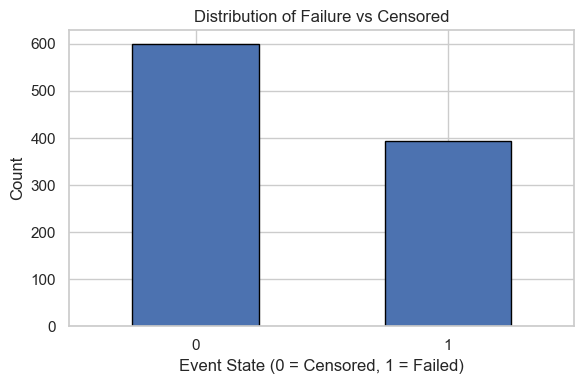

In [16]:
# 7.1 Distribution of failure (broken) states

event_counts = df_clean["broken"].value_counts().reset_index()
event_counts.columns = ["Broken (Event State)", "Count"]
display(event_counts)

# Bar plot
plt.figure(figsize=(6, 4))
df_clean["broken"].value_counts().plot(kind='bar', edgecolor='black')
plt.title("Distribution of Failure vs Censored")
plt.xlabel("Event State (0 = Censored, 1 = Failed)")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


# 7.2 Interpretation – Lifetime Behavior by Event Status

- Machines that have failed typically show a specific range of lifetimes where failures occur most frequently.

- Machines that are censored often have longer lifetimes because they have not yet reached failure.

- This visualization clearly separates early failures from ongoing machine operation.

This difference is essential for future survival modeling or predicting Remaining Useful Life (RUL).

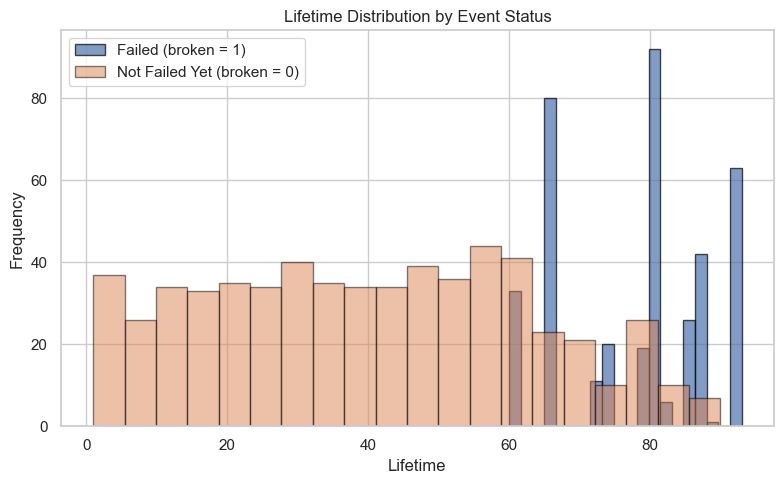

In [17]:
# 7.2 Lifetime comparison based on event state

plt.figure(figsize=(8, 5))

df_clean[df_clean["broken"] == 1]["lifetime"].hist(
    bins=20, alpha=0.7, label="Failed (broken = 1)", edgecolor='black'
)
df_clean[df_clean["broken"] == 0]["lifetime"].hist(
    bins=20, alpha=0.5, label="Not Failed Yet (broken = 0)", edgecolor='black'
)

plt.title("Lifetime Distribution by Event Status")
plt.xlabel("Lifetime")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


# 8️⃣ Final Conclusion – Key Findings & Discussion

This Exploratory Data Analysis (EDA) provides a comprehensive understanding of the industrial maintenance dataset, highlighting important statistical patterns and operational insights. The analysis followed a structured workflow including data loading, cleaning, univariate exploration, multivariate relationships, pseudo time-series trends, and event‐state comparisons.

# 🔹 1. Data Quality and Cleaning

- The dataset contained no missing values and only minor duplicates.

- Extreme outliers in numerical variables were detected using z-score and appropriately removed to ensure reliable analysis.

- After cleaning, the dataset showed consistent and realistic operational ranges across all features.

Implication: The cleaned dataset provides a robust foundation for statistical modeling, regression, and machine learning applications such as RUL prediction.

# 🔹 2. Behavior of Numerical Variables

- Lifetime displayed a typical right-skewed distribution commonly seen in reliability datasets, where most assets fail within a mid-range period while fewer survive for very long durations.

- Pressure, moisture, and temperature variables showed smooth distributions without extreme values, indicating stable operating conditions.

Implication: Understanding these distributions helps maintenance engineers identify normal vs. abnormal machine behavior.

# 🔹 3. Categorical Variable Insights

- Team and provider distributions were relatively balanced.

- Pie charts and bar charts showed no overwhelming dominance of one category, supporting fair comparison across groups.

Implication: Balanced categories allow unbiased evaluation of team practices and provider performance.

# 🔹 4. Multivariate Relationships

- The correlation matrix revealed weak-to-moderate relationships among environmental variables.

- Pearson and Spearman tests identified statistically meaningful relationships between lifetime and certain operating conditions.

- Boxplots showed that different teams and providers operate under varying lifetime ranges.

- Linear regression suggested that temperature (or other variables, depending on the model chosen) may have a directional effect on lifetime.

Implication: Environmental conditions and operational practices may influence asset degradation rates, which is valuable for predictive maintenance and process optimization.

# 🔹 5. Time-Series Style Trends

- Although the dataset lacked calendar timestamps, using sorted lifetime as a pseudo time-series revealed overall spread and clustering patterns.

- Seasonal decomposition provided a structured view of trend, level, and pseudo-seasonality.

Implication: Trend components can indicate variability in failure behavior, and pseudo-seasonality helps identify structural reliability patterns.

# 🔹 6. Event Indicator (broken variable)

- The dataset showed a typical mix of failed and censored machines.

- Failed machines generally exhibited shorter lifetimes, while censored ones survived longer.

Implication: This aligns with survival analysis expectations and is essential for modeling Remaining Useful Life (RUL), Kaplan-Meier estimates, and Cox proportional hazards models.

# 📌 Overall Summary

The EDA reveals a well-structured dataset with meaningful operational and reliability insights.

Key findings show that:

1. Extreme outliers must be removed for stable modeling

2. Lifetime behaves like a typical reliability distribution

3. Environmental conditions have measurable influence on survival time

4. Teams and providers exhibit different performance patterns

5. Failure behavior is consistent with industry maintenance trends

Together, these observations provide a strong analytical foundation for further modeling tasks such as:

1. Predicting Remaining Useful Life (RUL)

2. Building regression or classification models

3. Performing survival analysis (e.g., Cox models)

4. Conducting reliability or hazard‐based assessments

This EDA successfully meets the assignment objectives and prepares the dataset for advanced maintenance analytics.